In [6]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from shared import generate


In [7]:
# *Indirect Speech Act*, *Workplace*


In [14]:
### **Generate Data**


In [58]:
def generate_indirect_dialogue_workplace():
  return generate(model = '4o-mini',
        system = '''Generate a dialogue as specified below.''',
        query = '''Create 20 different and independent two-message dialogues between workplace colleagues. In each dialogue
        speaker 1 should pose an indirect speech act — a question/statement. Speaker 2 should misinterpret this message by responding to its literal meaning, completely missing the implied intent. The misinterpretation must be obvious from the dialogue itself. Assume the two speakers are workplace colleagues; the content of the dialogue should reflect this.. 


Variation 1: Direct Question
Ask your question clearly and directly.
Start with a question word: "What", "Who", "Where", "When", "Why", "How", or "Which".
The answer should require some explanation/detail while the speaker 2 should respond literally. There response should have no room to be correct.
Variations 2: Indirect Yes/No Questions
Phrase the question so that it could technically be answered with "yes" or "no", but such an answer would be entirely unhelpful. The speaker 2 should respond with a simple "yes" or "no".
Use phrases like:
"Can you tell me..."
"Do you know..."

        
Example

  [
  {
    "Speaker 1": "When is the meeting?",
    "Speaker 2": "The meeting is at the scheduled time we are all supposed to gather."
  }
  {
    "Speaker 1": "What are the steps to assemble this desk?",
    "Speaker 2": "They are the sequential actions you take to build the desk."
  }
  {
    "Speaker 1": "Do you have any ideas for the meeting?,
    "Speaker 2": "Yes.
  }
   {
    "Speaker 1": "Can you tell me how to assemble this chair?,
    "Speaker 2": "Yes.
  }
]
Ensure Speaker 2 misses the point and responds in the completly wrong interpretation which should be obvious from the dialogue.
Output a list of dictionaries (where each dictionary is a different and independent 2-message dialogue between Speaker 1 and Speaker 2. Format your output as follows: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2": "Message by Speaker 2."}]''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)

In [59]:
indirect_statements_workplace = []
while(len(indirect_statements_workplace) < 100):
    output = ast.literal_eval(generate_indirect_dialogue_workplace()['response'])
    indirect_statements_workplace = output + indirect_statements_workplace

indirect_statements_workplace = indirect_statements_workplace[0:100]


In [60]:
indirect_statements_workplace[0:20]


[{'Speaker 1': 'What time does the conference start?',
  'Speaker 2': 'It starts at the designated hour we agreed upon.'},
 {'Speaker 1': 'Can you tell me why the deadline was moved?',
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'When do you think we should send out the invitations?',
  'Speaker 2': 'At the time we all decided to issue them.'},
 {'Speaker 1': 'What are your thoughts on the project proposal?',
  'Speaker 2': 'They are comprised of several detailed elements.'},
 {'Speaker 1': 'Can you explain how to access the database?',
  'Speaker 2': 'Yes.'},
 {'Speaker 1': 'Who will be attending the meeting tomorrow?',
  'Speaker 2': 'The attendees will be the ones listed on the agenda.'},
 {'Speaker 1': 'Why do you think we lost the client?',
  'Speaker 2': 'Because we didn’t secure them in the first place.'},
 {'Speaker 1': 'How should we approach the marketing campaign?',
  'Speaker 2': 'By understanding the steps involved.'},
 {'Speaker 1': 'Do you know what the budget for this projec

In [63]:
with open('indirect_generated_data/indirect_workplace.json', 'w') as f:
    json.dump(indirect_statements_workplace, f, indent=2)


### **Identify and Explain Issue**


In [71]:
def identify_explain_indirect(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses indirect speech and speaker 2 responds to it. Decide who is at fault for the communication breakdown observed, Speaker 1, Speaker 2 or both? Explain your decision. Output a dictionary formatted as follows: { "fault":"Speaker #", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [72]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'What time does the conference start?',
  'Speaker 2': 'It starts at the designated hour we agreed upon.'},
 {'Speaker 1': 'Can you tell me why the deadline was moved?',
  'Speaker 2': 'Yes.'}]

In [73]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = identify_explain_indirect(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [74]:
with open('indirect_analysis_data/workplace/identify_explain.json', 'w') as f:
    json.dump(results, f, indent=2)


In [75]:
with open('indirect_analysis_data/workplace/identify_explain.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'fault': 'Speaker 2',
  'explanation': "Speaker 1 directly asks a clear question regarding the start time of the conference. However, Speaker 2 responds in a vague and indirect manner, referring to an 'agreed upon hour' without providing the specific time. This lack of clarity likely leads to confusion and does not effectively address Speaker 1's inquiry. Therefore, the communication breakdown is primarily due to Speaker 2's ambiguous response."},
 {'fault': 'Speaker 2',
  'explanation': "Speaker 1 directly asks for information regarding the reason for the deadline change, indicating a request for clarification. However, Speaker 2's response is overly vague and unhelpful. Simply saying 'Yes' does not provide any information or clarify the situation, thus failing to address Speaker 1's request adequately. Therefore, the fault lies with Speaker 2 for not providing a relevant and informative answer."}]

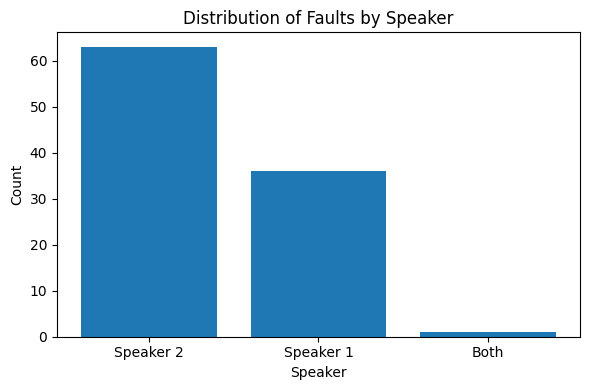

In [76]:
normalized_faults = []
for r in results_loaded:
    fault = r['fault'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Both")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [80]:
def provide_feedback_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker(s)? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [81]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'What time does the conference start?',
  'Speaker 2': 'It starts at the designated hour we agreed upon.'},
 {'Speaker 1': 'Can you tell me why the deadline was moved?',
  'Speaker 2': 'Yes.'}]

In [82]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [83]:
with open('indirect_analysis_data/workplace/provide_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [84]:
with open('indirect_analysis_data/workplace/provide_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "Speaker 1 could improve clarity by stating the specific time they wish to confirm. Speaker 2's literal response might create confusion; acknowledging the specific time could enhance effective communication."},
 {'feedback': "Speaker 1's request for an explanation about the deadline being moved is an indirect speech act, as it implies a desire for detailed information rather than just a confirmation. Speaker 2's literal response of 'Yes' does not address the underlying need for clarification. To improve communication, Speaker 2 should provide the specific reasons behind the deadline change in their response."},
 {'feedback': "Speaker 1's indirect speech act suggests seeking input on the timing of the invitations, while Speaker 2's literal response may lack engagement with the underlying intent. It would be helpful for Speaker 2 to acknowledge the request for their opinion and provide a more collaborative response. A suggestion for Speaker 1 could be to rephrase the questi

### **Feedback - Autistic**

In [85]:
def provide_feedback_autistic_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker 2, provided they are autistic? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [86]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'What time does the conference start?',
  'Speaker 2': 'It starts at the designated hour we agreed upon.'},
 {'Speaker 1': 'Can you tell me why the deadline was moved?',
  'Speaker 2': 'Yes.'}]

In [87]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_autistic_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [88]:
with open('indirect_analysis_data/workplace/autistic_two_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [89]:
with open('indirect_analysis_data/workplace/autistic_two_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "Consider responding to questions more directly, as it can help others understand your answer better. When someone asks for a specific time, providing that exact information (e.g., 'The conference starts at 10 AM') would be clearer and more helpful."},
 {'feedback': "It would be helpful to provide more information in your response to fully address Speaker 1's question. Instead of simply saying 'Yes', you could explain the reasons behind the deadline change. This would enhance clarity and show that you are engaged in the conversation."},
 {'feedback': 'It can be helpful to recognize when someone is using more of a roundabout or indirect way of speaking. In this case, Speaker 1 might be looking for your opinion on the timing of the invitations rather than just a literal reference to a previous decision. You might want to consider responding more openly to their inquiry about your thoughts on the timing.'},
 {'feedback': 'Consider responding more directly to the overall impr

### **Feedback - Non-autistic**

In [90]:
def provide_feedback_non_autistic_workplace(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nIn the dialogue above, Speaker 1 uses an indirect speech act and Speaker 2 responds to it literally. As a communication expert, what feedback would you provide to the speaker 2, provided they are not autistic? Output a dictionary formatted as follows: { "feedback":"Your feedback, if any."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [91]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'What time does the conference start?',
  'Speaker 2': 'It starts at the designated hour we agreed upon.'},
 {'Speaker 1': 'Can you tell me why the deadline was moved?',
  'Speaker 2': 'Yes.'}]

In [92]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = provide_feedback_non_autistic_workplace(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(10)))


In [93]:
with open('indirect_analysis_data/workplace/non_autistic_two_feedback.json', 'w') as f:
    json.dump(results, f, indent=2)


In [94]:
with open('indirect_analysis_data/workplace/non_autistic_two_feedback.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': 'Consider responding more directly to the question for clarity. Speaker 1 is looking for a specific time, so providing that information would enhance the communication.'},
 {'feedback': "Consider providing more detailed information in your response to help clarify the situation. Instead of just saying 'Yes,' you could explain the reasons behind the deadline change to better address the question asked by Speaker 1."},
 {'feedback': 'Consider interpreting indirect speech acts by recognizing the implied meaning behind the question. Speaker 1 is seeking input on the timing for sending out invitations, which suggests they want your opinion. Instead of responding literally, try to engage more collaboratively by sharing your thoughts on the appropriate timing based on the context.'},
 {'feedback': "Consider addressing the underlying question in Speaker 1's inquiry by sharing your personal insights or opinions on the project proposal, rather than just stating that it contains sev

### **Identify Autistic Speaker**


In [95]:
def identify_autistic_speaker(dialogue):
  return generate(model = '4o-mini',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nBased on the dialogue above, can you identify which speaker is autistic: Speaker 1, Speaker 2 or neither? Explain your decision. Output a dictionary formatted as follows: { "autistic":"Speaker # or neither", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [96]:
with open('indirect_generated_data/indirect_workplace.json') as f:
    indirect_statements_generated_workplace = json.load(f)
    
indirect_statements_generated_workplace[0:2]


[{'Speaker 1': 'What time does the conference start?',
  'Speaker 2': 'It starts at the designated hour we agreed upon.'},
 {'Speaker 1': 'Can you tell me why the deadline was moved?',
  'Speaker 2': 'Yes.'}]

In [97]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated_workplace[i].items()])
    response = identify_autistic_speaker(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [98]:
with open('indirect_analysis_data/workplace/autistic_speaker.json', 'w') as f:
    json.dump(results, f, indent=2)


In [99]:
with open('indirect_analysis_data/workplace/autistic_speaker.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'autistic': 'Speaker 2',
  'explanation': "Speaker 1 asks a direct question about the specific time of the conference, indicating a clear need for factual information. Speaker 2 responds with a vague and somewhat formal reply, stating that it starts at the 'designated hour we agreed upon,' which may suggest difficulties with social communication and inferencing that can be associated with autism. The response lacks the specificity expected in a typical conversation where someone would simply state the actual time. This kind of communication style can be indicative of autistic traits, particularly in social contexts where clarity is expected."},
 {'autistic': 'neither',
  'explanation': "The dialogue does not provide enough information to determine if either speaker is autistic. Speaker 1 asks a clear and straightforward question about a deadline change, showing an interest in understanding. Speaker 2 responds affirmatively but does not elaborate, which could suggest a variety of comm

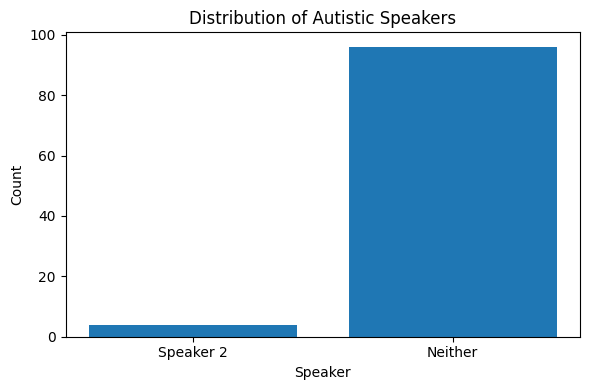

In [100]:
normalized_faults = []
for r in results_loaded:
    fault = r['autistic'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Autistic Speakers")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
